In [219]:
import os, sys
sys.path.append('../src/')

import pandas as pd
import numpy as np
import pickle
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt

import json
with open('../src/configs/BBT_Tiingo_MM.json','r') as file:
    config = json.load(file)

In [220]:
config

{'data_name': 'BBT_Tiingo',
 'spot_name': 'log return bitcoin',
 'future_name': 'log return future',
 'calibration_method': 'MM',
 'q_arr': [0.05, 0.1, 0.9, 0.95],
 'k_ERM': [10],
 'q_arr_ES': [0.01, 0.05],
 'q_arr_VaR': [0.01, 0.05],
 'h_Clip': [0, 99999]}

In [221]:
spot_name = config['spot_name']
future_name = config['future_name']

In [222]:
data_name = config['data_name']
calibration_method = config['calibration_method']

data_path = '../processed_data/%s/'%data_name

train_path = data_path+'train/'
test_path = data_path+'test/'

result_path = '../results/%s/%s/'%(data_name, calibration_method)
OHR = pd.read_csv(result_path+'OHR.csv')

In [223]:
copulae = np.unique(OHR.copula)
risk_measures = np.unique(OHR.loc[:,'risk measure'])

In [224]:
c = copulae[0]
rm = risk_measures[0]

def make_rh(c, rm):

    i_rm = OHR.loc[:,'risk measure'] == rm
    i_c = OHR.copula == c
    i = i_c&i_rm

    ohr = OHR.loc[i,:]
    ohr.reset_index(drop=True, inplace=True)

    rh_arr = []
    date_arr = []
    for i in range(len(ohr)):
        file = ohr.loc[i,'file']
        h = ohr.loc[i, 'OHR']
        test = pd.read_csv(test_path+file)
        rs = test.loc[:,spot_name]
        rf = test.loc[:,future_name]
        rh = rs - h*rf
        rh_arr.append(rh)
        date_arr.append(test.Date)
        
    df_arr = []
    for i in range(len(ohr)):
        df = pd.DataFrame([date_arr[i],rh_arr[i]]).T
        df.columns = ['Date', 'rh']
        df_arr.append(df)
        
    results = pd.concat(df_arr)
    results.Date = pd.to_datetime(results.Date)
    results.sort_values('Date', ascending=False, inplace=True)
    return results

In [225]:
results = dict()
for c in copulae:
    for rm in risk_measures:
        results[(c, rm)]= make_rh(c, rm)

In [212]:
def SD(c1, rm1, c2, rm2, j, n_grids=2000, boxplot=False, lower=False):
    
    file_name1 = c1+'_'+rm1
    file_name2 = c2+'_'+rm2
    
    if file_name1 == file_name2:
        print('same')
        return 
    
#     r1 = pd.read_csv('../results/future_brr_new/MM/rhs/'+file_name1).iloc[:,-1]
#     r2 = pd.read_csv('../results/future_brr_new/MM/rhs/'+file_name2).iloc[:,-1]
    r1 = results[(c1,rm1)].rh
    r2 = results[(c2,rm2)].rh
    
    if lower:
        _max = 1
    else:
        _max = np.max([np.max(r1), np.max(r2)])
        
    _min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
    x = np.linspace(_min, _max, n_grids) # grids

    ecdf1 = ECDF(r1)
    ecdf2 = ECDF(r2)

    S1_1 = ecdf1(x)
    S1_2 = ecdf2(x)

    S2_1 = np.cumsum(ecdf1(x))
    S2_2 = np.cumsum(ecdf2(x))

    S3_1 = np.cumsum(S2_1)
    S3_2 = np.cumsum(S2_2)

    if j == 1:
        plt.plot(x, S1_1, label=file_name1)
        plt.plot(x, S1_2, label=file_name2)
        
        if np.mean((S1_1 < S1_2))==0:
            print('%s FOSD %s from %.3f to %.3f' %(file_name2, file_name1,-np.inf,np.inf))
        else:
            a_FOSD = np.min(x[(S1_1 < S1_2)])
            b_FOSD = np.max(x[(S1_1 < S1_2)])

            if np.argmin(S1_1 <= S1_2) == 0:
                a_FOSD = -np.inf
            if (np.argmax(S1_1 <= S1_2)==len(x)+1) & (~lower):
                b_FOSD = np.inf
                
            if b_FOSD < a_FOSD:
                b_FOSD = np.inf

            plt.title('FOSD')
            print('%s FOSD %s from %.3f to %.3f' %(file_name2, file_name1, a_FOSD, b_FOSD))
            plt.legend()

    elif j == 2:
        plt.plot(x, S2_1, label=file_name1)
        plt.plot(x, S2_2, label=file_name2)
        
        if np.mean((S2_1 < S2_2))==0:
            print('%s SOSD %s from %.3f to %.3f' %(file_name2, file_name1,-np.inf,np.inf))

        else:
            a_SOSD = x[np.argmin(S2_1 <= S2_2)]
            b_SOSD = x[np.argmax(S2_1 <= S2_2)]

            if np.argmin(S2_1 <= S2_2) == 0:
                a_SOSD = -np.inf
            if (np.argmax(S2_1 <= S2_2)==len(x)+1) & (~lower):
                b_SOSD = np.inf

            if b_SOSD < a_SOSD:
                b_SOSD = np.inf
                
            print('%s SOSD %s from %.3f to %.3f' %(file_name2, file_name1, a_SOSD, b_SOSD))
            plt.title('SOSD')
            plt.legend()
    
    elif j == 3:
        plt.plot(x, S3_1, label=file_name1)
        plt.plot(x, S3_2, label=file_name2)
        
        if np.mean((S3_1 < S3_2))==0:
            print('%s TOSD %s from %.3f to %.3f' %(file_name2, file_name1,-np.inf,np.inf))
        else:
            a_TOSD = np.min(x[(S3_1 < S3_2)])
            b_TOSD = np.max(x[(S3_1 < S3_2)])

            if np.argmin(S3_1 <= S3_2) == 0:
                a_TOSD = -np.inf
            if (np.argmax(S3_1 <= S3_2)==len(x)+1) & (~lower):
                b_TOSD = np.inf
            
            if b_TOSD < a_TOSD:
                b_TOSD = np.inf

            print('%s TOSD %s from %.3f to %.3f' %(file_name2, file_name1,-np.inf,np.inf))

            plt.title('TOSD')
            plt.legend()
    else:
        print('j must be 1,2 or 3')
    
    if boxplot:
        plt.figure()
        plt.boxplot([r1, r2], positions=[1,2])
#         plt.xticks([1,2],[c1+'_'+rm1, c2+'_'+rm2])
        plt.title('Returns')

t_Copula_Variance SOSD Gaussian_Variance from -inf to inf


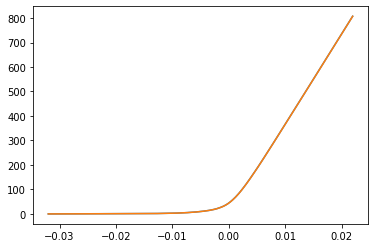

In [213]:
c1 = 't_Copula'
c2 = 'Gaussian'
rm1 = 'Variance'
rm2 = 'Variance'

# SD(c1, rm1, c2, rm2, 2)
SD(c2, rm2, c1, rm1, 2)

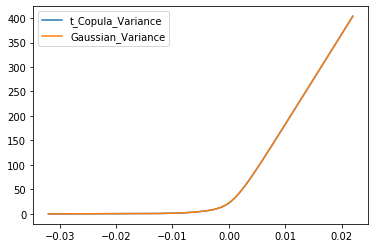

In [214]:
c1 = 't_Copula'
c2 = 'Gaussian'

rm1 = 'Variance'
rm2 = 'Variance'

file_name1 = c1+'_'+rm1
file_name2 = c2+'_'+rm2


n_grids= 1000
r1 = results[(c1,rm1)].rh
r2 = results[(c2,rm2)].rh


_max = np.max([np.max(r1), np.max(r2)])

_min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
x = np.linspace(_min, _max, n_grids) # grids

ecdf1 = ECDF(r1)
ecdf2 = ECDF(r2)

S1_1 = ecdf1(x)
S1_2 = ecdf2(x)

S2_1 = np.cumsum(ecdf1(x))
S2_2 = np.cumsum(ecdf2(x))

S3_1 = np.cumsum(S2_1)
S3_2 = np.cumsum(S2_2)

plt.plot(x, S2_1, label=file_name1)
plt.plot(x, S2_2, label=file_name2)
plt.legend()

In [215]:
a_SOSD = x[np.argmin(S2_1 <= S2_2)]
b_SOSD = x[np.argmax(S2_1 <= S2_2)]
print(a_SOSD, b_SOSD)

-0.03199178273271143 -0.03199178273271143
